# Sharp regression discontinuity with scikit-learn models

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel
from sklearn.linear_model import LinearRegression

import causalpy as cp

In [2]:
%config InlineBackend.figure_format = 'retina'

## Load data

In [3]:
data = cp.load_data("rd")
data.head()

,x,y,treated
0,-0.932739,-0.091919,False
1,-0.930778,-0.382663,False
2,-0.929110,-0.181786,False
3,-0.907419,-0.288245,False
4,-0.882469,-0.420811,False


## Linear, main-effects model

In [4]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

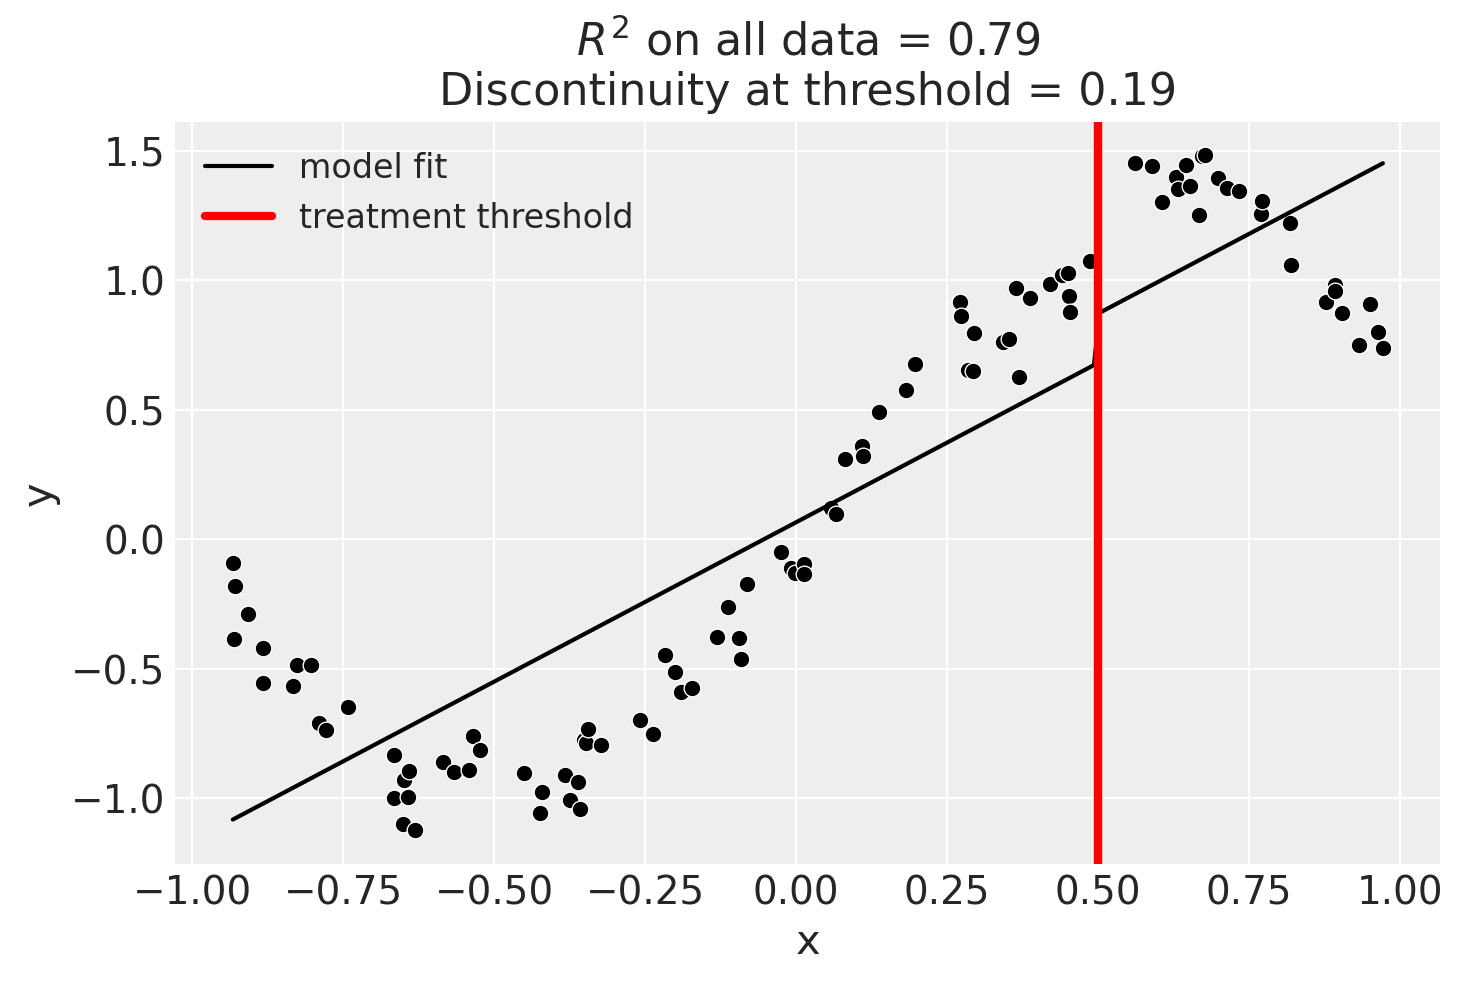

In [5]:
fig, ax = result.plot()

In [6]:
result.summary(round_to=3)

Difference in Differences experiment
Formula: y ~ 1 + x + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.19


Model coefficients:
  Intercept      	         0
  treated[T.True]	      0.19
  x              	      1.23


## Linear, main-effects, and interaction model

In [7]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

In [8]:
result.plot();

Though we can see that this does not give a good fit of the data almost certainly overestimates the discontinuity at threshold.

In [9]:
result.summary(round_to=3)

Difference in Differences experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.92


Model coefficients:
  Intercept        	         0
  treated[T.True]  	      2.47
  x                	      1.32
  x:treated[T.True]	     -3.11


## Using a bandwidth

One way how we could deal with this is to use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the threshold. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

In [10]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

result.plot();

We could even go crazy and just fit intercepts for the data close to the threshold. But clearly this will involve more estimation error as we are using less data.

In [11]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

result.plot();

## Using Gaussian Processes

Now we will demonstrate how to use a scikit-learn model. 

In [12]:
kernel = 1.0 * ExpSineSquared(1.0, 5.0) + WhiteKernel(1e-1)
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    model=GaussianProcessRegressor(kernel=kernel),
    treatment_threshold=0.5,
)

In [13]:
fig, ax = result.plot()

## Using basis splines

In [14]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

In [15]:
fig, ax = result.plot()

In [16]:
result.summary(round_to=3)

Difference in Differences experiment
Formula: y ~ 1 + bs(x, df=6) + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.41


Model coefficients:
  Intercept      	         0
  treated[T.True]	     0.407
  bs(x, df=6)[0] 	    -0.594
  bs(x, df=6)[1] 	     -1.07
  bs(x, df=6)[2] 	     0.278
  bs(x, df=6)[3] 	      1.65
  bs(x, df=6)[4] 	      1.03
  bs(x, df=6)[5] 	     0.567


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics. Note that for Regression Discontinuity, the effect is a single scalar (the discontinuity at the threshold), similar to Difference-in-Differences.

:::{note}
**OLS vs PyMC Models**: When using OLS models (scikit-learn), the `effect_summary()` provides **confidence intervals** and **p-values** (frequentist inference), rather than the posterior distributions, HDI intervals, and tail probabilities provided by PyMC models (Bayesian inference). OLS tables include: mean, CI_lower, CI_upper, and p_value, but do not include median, tail probabilities (P(effect>0)), or ROPE probabilities.
:::


In [17]:
# Generate effect summary for the final model (basis splines)
stats = result.effect_summary()
stats.table

,mean,ci_lower,ci_upper,p_value
discontinuity,0.407683,0.388323,0.427043,0.0


In [18]:
# View the prose summary
print(stats.text)

The discontinuity at threshold was 0.41 (95% CI [0.39, 0.43]), with a p-value of 0.000.


In [19]:
# You can specify the direction of interest (e.g., testing for an increase)
stats_increase = result.effect_summary(direction="increase")
stats_increase.table

,mean,ci_lower,ci_upper,p_value
discontinuity,0.407683,0.388323,0.427043,0.0
